In [45]:
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import accuracy_score
from solarnet.models.image_classification import ImageClassification
from solarnet.models.simclr import SimCLR
from solarnet.data.sdo_benchmark import SDOBenchmarkDataModule, SDOBenchmarkDataset
from solarnet.utils.metrics import classification_metrics,stat_scores,stats_metrics
from solarnet.utils.plots import plot_confusion_matrix, plot_image_grid
import optuna

In [2]:
# Define the PyTorch model
model = SimCLR.from_pretrained(Path("..") / "models" / "ssl_bz_2011")

In [3]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

path_train = Path("../data") / "sdo-benchmark" / "training"
dataset_train = SDOBenchmarkDataset(path_train / "meta_data.csv", path_train,
channel="magnetogram",
transform=transform,
target_transform=lambda x: 0 if x < 1e-6 else 1,
time_steps=3,
)

path_test = Path("../data") / "sdo-benchmark" / "test"
dataset_test = SDOBenchmarkDataset(path_test / "meta_data.csv", path_test,
channel="magnetogram",
transform=transform,
target_transform=lambda x: 0 if x < 1e-6 else 1,
time_steps=3,
)


In [4]:
dataset_train_vr = ([], [])
dataset_test_vr = ([], [])
with torch.no_grad():
    for X, y in tqdm(dataset_train):
        vector_representation = model(X.unsqueeze(0))[0].detach().numpy()
        dataset_train_vr[0].append(vector_representation)
        dataset_train_vr[1].append(y)

    for X, y in tqdm(dataset_test):
        vector_representation = model(X.unsqueeze(0))[0].detach().numpy()
        dataset_test_vr[0].append(vector_representation)
        dataset_test_vr[1].append(y)

100%|██████████| 865/865 [00:24<00:00, 35.32it/s]


In [5]:
from sklearn.cluster import KMeans, DBSCAN

In [42]:
cluster = KMeans(n_clusters=2, max_iter=100000, n_init=30).fit(dataset_train_vr[0])
# cluster = DBSCAN().fit(dataset_train_vr[0])

In [43]:
labels = cluster.labels_
labels[:5]

array([1, 1, 1, 1, 1], dtype=int32)

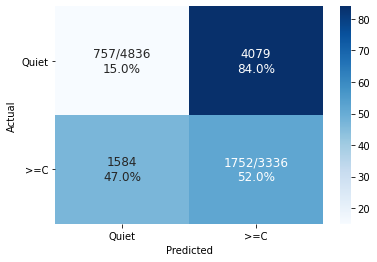

In [44]:
plot_confusion_matrix(dataset_train_vr[1], labels, labels=["Quiet", ">=C"])

In [51]:

# ids = random.sample(range(len(dataset)), N_IMAGES)

# images = [dataset[i][0][0] for i in ids]
images = [X[0] for X, y in dataset_train]
# images = dataset_train_vr[0]

images_0 = [img for i, img in enumerate(images) if labels[i] == 0]
images_1 = [img for i, img in enumerate(images) if labels[i] == 1]

# flux_to_class = flux_to_class_builder([{"Quiet": "< 1e-6"},{">=C": ">= 1e-6"}])
# labels = [flux_to_class(dataset[i][1]) for i in ids]


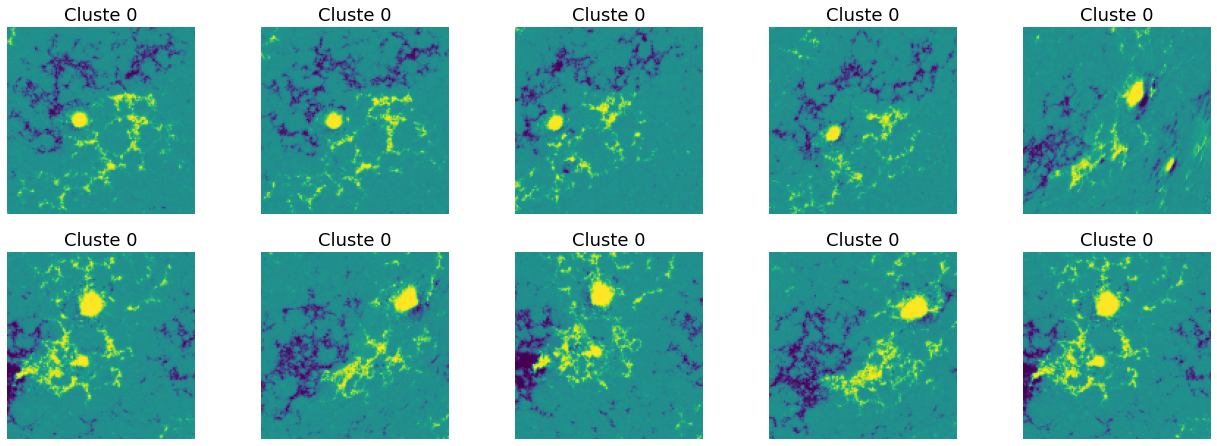

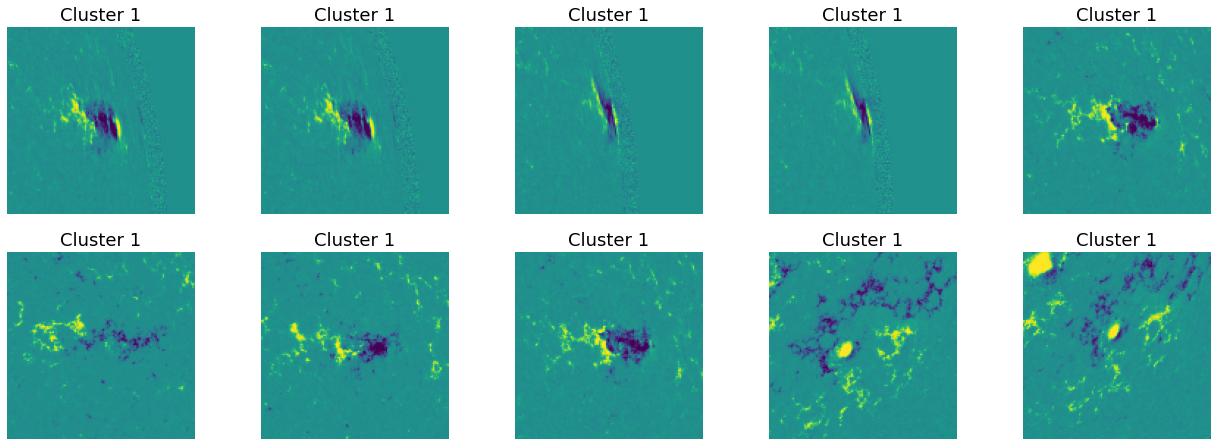

In [52]:
N_IMAGES = 10
plot_image_grid(images_0, y=[0]*len(images_0), columns=5, max_images=N_IMAGES,
                labels=["Cluste 0","Cluster 1"], label_font_size=18,)

plot_image_grid(images_1, y=[1]*len(images_1), columns=5, max_images=N_IMAGES,
                labels=["Cluster 0","Cluster 1"], label_font_size=18,)